## Integrantes
### Juan David Rios Nisperuza - 202215787
### Laura Julieth Carretero Serrano - 202214922

## EJERCICIO 1: Método eConstraint en Pyomo

Deleting model components (O_f2).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
Deleting model components (epsilon_constraint).
Deleting model components (O_f2).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
Deleting model components (epsilon_constraint).
Deleting model components (O_f2).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
Deleting model components (epsilon_constraint).
Deleting model components (O_f2).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
Deleting model components (epsilon_constraint).
Deleting model components (O_f2).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
Deleting model components (epsilon_constrai

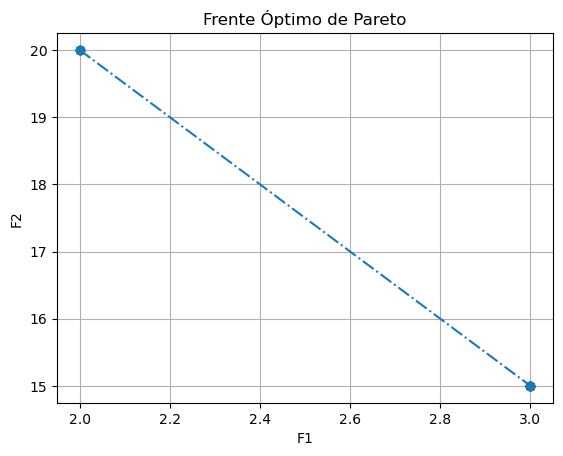

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory

def delete_component(Model, comp_name):

        list_del = [vr for vr in vars(Model)
                    if comp_name == vr
                    or vr.startswith(comp_name + '_index')
                    or vr.startswith(comp_name + '_domain')]

        list_del_str = ', '.join(list_del)
        print('Deleting model components ({}).'.format(list_del_str))

        for kk in list_del:
            Model.del_component(kk)

numIteraciones=11 
iteraciones=range(numIteraciones)

epsilon_min = 2
epsilon_max = 5
epsilon_values = [epsilon_min + i * (epsilon_max - epsilon_min) / (numIteraciones - 1) for i in iteraciones]


Model = ConcreteModel()

numNodes = 5
Model.N=RangeSet(1,numNodes)

Model.h =Param(Model.N, Model.N, mutable=True)

for i in Model.N:
    for j in Model.N:
        Model.h[i,j] = 999

Model.h[1,2] = 1
Model.h[1,3] = 1
Model.h[2,5] = 1
Model.h[3,4] = 1
Model.h[4,5] = 1

Model.c =Param(Model.N, Model.N, mutable=True)

for i in Model.N:
    for j in Model.N:
        Model.c[i,j] = 999

Model.c[1,2] = 10
Model.c[1,3] = 5
Model.c[2,5] = 10
Model.c[3,4] = 5
Model.c[4,5] = 5
        
s = 1
d = 5
        
Model.x = Var(Model.N,Model.N, domain=Binary)
Model.f1 = sum(Model.x[i,j] * Model.h[i,j] for i in Model.N for j in Model.N)
Model.f2 = sum(Model.x[i,j] * Model.c[i,j] for i in Model.N for j in Model.N)

cont=-1
f1_vec=[]
f2_vec=[]

for epsilon in epsilon_values:
    
    Model.O_f2 = Objective(expr=Model.f2, sense=minimize)


    def source_rule(Model, i):
        if i == s:
            return sum(Model.x[i,j] for j in Model.N) == 1
        else:
            return Constraint.Skip

    Model.source = Constraint(Model.N, rule=source_rule)

    def destination_rule(Model, j):
        if j == d:
            return sum(Model.x[i,j] for i in Model.N) == 1
        else:
            return Constraint.Skip

    Model.destination = Constraint(Model.N, rule=destination_rule)

    def intermediate_rule(Model, i):
        if i != s and i != d:
            return sum(Model.x[i,j] for j in Model.N) - sum(Model.x[j,i] for j in Model.N) == 0
        else:
            return Constraint.Skip

    Model.intermediate = Constraint(Model.N, rule=intermediate_rule)
    Model.epsilon_constraint = Constraint(expr=Model.f1 <= epsilon)

    SolverFactory('glpk').solve(Model)
    valorF1 = value(Model.f1)
    valorF2 = value(Model.f2)
    f1_vec.append(valorF1)
    f2_vec.append(valorF2)
    delete_component(Model, 'O_f2')
    delete_component(Model, 'source')
    delete_component(Model, 'destination')
    delete_component(Model, 'intermediate')
    delete_component(Model, 'epsilon_constraint')


plt.plot(f1_vec,f2_vec,'o-.');
plt.title('Frente Óptimo de Pareto');
plt.xlabel('F1')
plt.ylabel('F2')
plt.grid(True);
plt.show()

## EJERCICIO 2: Implementación del Algoritmo Simplex

In [2]:
import numpy as np
def simplex(coef_objetivo, matriz_restricciones, lado_derecho):
    num_restricciones, num_variables = matriz_restricciones.shape
    tableau = np.zeros((num_restricciones + 1, num_variables + num_restricciones + 1))
    
    tableau[:-1, :num_variables] = matriz_restricciones
    tableau[:-1, num_variables:num_variables + num_restricciones] = np.eye(num_restricciones)
    tableau[:-1, -1] = lado_derecho

    tableau[-1, :num_variables] = -coef_objetivo

    while True:
        if np.all(tableau[-1, :-1] >= 0):
            print("Solución óptima encontrada.")
            break
        
        col_pivote = np.argmin(tableau[-1, :-1])
        
        razones = []
        for i in range(num_restricciones):
            if tableau[i, col_pivote] > 0:
                razones.append(tableau[i, -1] / tableau[i, col_pivote])
            else:
                razones.append(np.inf)
        
        fila_pivote = np.argmin(razones)

        if razones[fila_pivote] == np.inf:
            print("El problema es ilimitado.")
            return None
        elemento_pivote = tableau[fila_pivote, col_pivote]
        tableau[fila_pivote, :] /= elemento_pivote
        
        for i in range(num_restricciones + 1):
            if i != fila_pivote:
                tableau[i, :] -= tableau[i, col_pivote] * tableau[fila_pivote, :]
    solucion = np.zeros(num_variables)
    for i in range(num_restricciones):
        if np.count_nonzero(tableau[i, :num_variables]) == 1:
            col = np.where(tableau[i, :num_variables] == 1)[0][0]
            solucion[col] = tableau[i, -1]
    
    return solucion, tableau[-1, -1]


In [3]:
coef_objetivo = np.array([3, 2]) 
matriz_restricciones = np.array([[2, 1], [1, 1], [1, 0]])  
lado_derecho = np.array([100, 80, 40])  

solucion, valor_optimo = simplex(coef_objetivo, matriz_restricciones, lado_derecho)

print("Solución óptima:", solucion)
print("Valor óptimo de la función objetivo:", valor_optimo)

Solución óptima encontrada.
Solución óptima: [20. 60.]
Valor óptimo de la función objetivo: 180.0


### Meta codigo


La función simplex recibe tres parámetros principales: coef_objetivo, que es un arreglo con los coeficientes de la función objetivo que queremos optimizar; matriz_restricciones, que es una matriz que contiene los coeficientes de las restricciones lineales; y lado_derecho, que es un vector que representa el lado derecho de cada restricción. Estos parámetros permiten establecer el sistema de ecuaciones lineales que define el problema.

Luego, el código crea un tableau para representar el problema en forma matricial. Este tableau facilita la aplicación del método simplex mediante operaciones en fila. Para su configuración inicial, se calcula el número de restricciones y variables a partir de la matriz_restricciones. Posteriormente, se agrega una matriz identidad para representar las variables de holgura, que convierte las desigualdades en igualdades. La última fila del tableau contiene los coeficientes de la función objetivo negada, ya que el método Simplex por defecto está diseñado para maximizar.

En cada iteración del método, se realiza un conjunto de pasos específicos. Primero, se identifica la columna pivote buscando el elemento más negativo en la última fila del tableau (excluyendo el último valor, que corresponde a los resultados del sistema). Este elemento indica cuál variable incrementará para maximizar el valor de la función objetivo. A continuación, se calculan los cocientes entre los valores del lado derecho y los valores correspondientes en la columna pivote. Esto permite identificar la fila pivote, que es donde se encuentra el menor de estos cocientes y determina el próximo valor en la base. Si todos los cocientes son infinitos, el problema es ilimitado y no tiene una solución óptima.

Después de identificar el pivote, el código procede con la operación de pivoteo. La fila pivote se normaliza dividiéndola por el valor del elemento pivote, y luego se realizan operaciones de eliminación gaussiana en el resto de filas para asegurarse de que todos los elementos en la columna pivote (excepto el de la fila pivote) sean cero. Esto permite avanzar en el proceso de optimización del tableau, actualizando los valores y manteniendo la factibilidad del sistema.

Cuando se cumple la condición de que no hay elementos negativos en la última fila (excepto el último elemento), se ha alcanzado la solución óptima. La función entonces extrae los valores de las variables básicas de la matriz tableau, identificándolas por aquellas columnas que tienen un único valor no nulo. Al final, la función retorna el vector de solución con los valores de las variables y el valor óptimo de la función objetivo.